# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster

csvPath = "data/"
file1 = "movies.csv"
file2 = "ratings.csv"
file3 = "tags.csv"

df_movies  = pd.DataFrame(pd.read_csv(csvPath + file1))
df_ratings = pd.DataFrame(pd.read_csv(csvPath + file2))
df_tags    = pd.DataFrame(pd.read_csv(csvPath + file3))

# visulize raw data
print("df_movies:")
print(df_movies.head())

print("\ndf_ratings:")
print(df_ratings.head())

print("\ndf_tags:")
print(df_tags.head())


df_movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

df_ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

df_tags:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996

# Part A: combining rating and tags to find the relation between rating and tag.

For example, Horror movie tends to have lower rating compared to other genres, but what about tags? 
Are there some tags indicate high rating?

Note:
1) some users tend to give high rating, so standardize the rating.

In [2]:
# for i in 
set_user_tags = set(df_tags['userId'])
set_user_rate = set(df_ratings['userId'])

scale_rate = {} # userID: highest score, lowest score
for i in set_user_rate:
    scale_rate[i] = [0, 0]
    scale_rate[i][0] = df_ratings[df_ratings['userId'] == i]['rating'].max()
    scale_rate[i][1] = df_ratings[df_ratings['userId'] == i]['rating'].min()
# print(df_ratings[df_ratings['userId'] == 2])
# print(scale_rate[2])

tag2rate = {} # tag : rate
for i in set_user_tags&set_user_rate:          # find the user who rates movie and tags moive
    temp_tags = df_tags[df_tags['userId']==i]
    temp_rate = df_ratings[df_ratings['userId']==i]
    set_movie_tags = set(temp_tags['movieId'])
    set_movie_rate = set(temp_rate['movieId'])
    for j in set_movie_tags&set_movie_rate:    # find the movie that has both tags and rates
        this_rate = temp_rate[temp_rate['movieId'] == j]['rating'].iloc[0]
        scaled_rate = (this_rate - scale_rate[i][1]) / (scale_rate[i][0] - scale_rate[i][1])
        this_tag = temp_tags[temp_tags['movieId'] == j]['tag']
        for k in range(this_tag.shape[0]):
            tag = this_tag.iloc[k]
            if tag in tag2rate:
                tag2rate[tag].append(scaled_rate)
            else:
                tag2rate[tag] = [scaled_rate]


Text(0, 0.5, 'propotion')

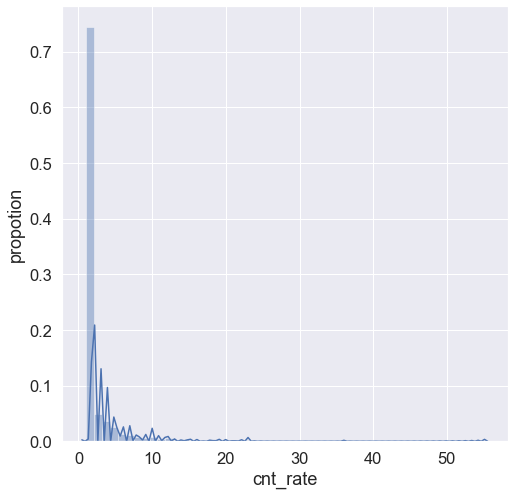

In [3]:
x_tags = []
y_cnt_rate = []
for t in tag2rate:
    x_tags.append(t)
    y_cnt_rate.append(len(tag2rate[t]))

plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)
sns.distplot(y_cnt_rate)
plt.xlabel("cnt_rate")
plt.ylabel("propotion")


From the fig, it's obviouse that most of the tags (moives) will have only 1 rate associated with it, so it will be very likely biased by the user who rate that moive. Let's remove the tags that has less than 10 rate and see the average score of these tags.

[Text(0, 0.5, ''), (0, 5), Text(0.5, 0, 'Average rating')]

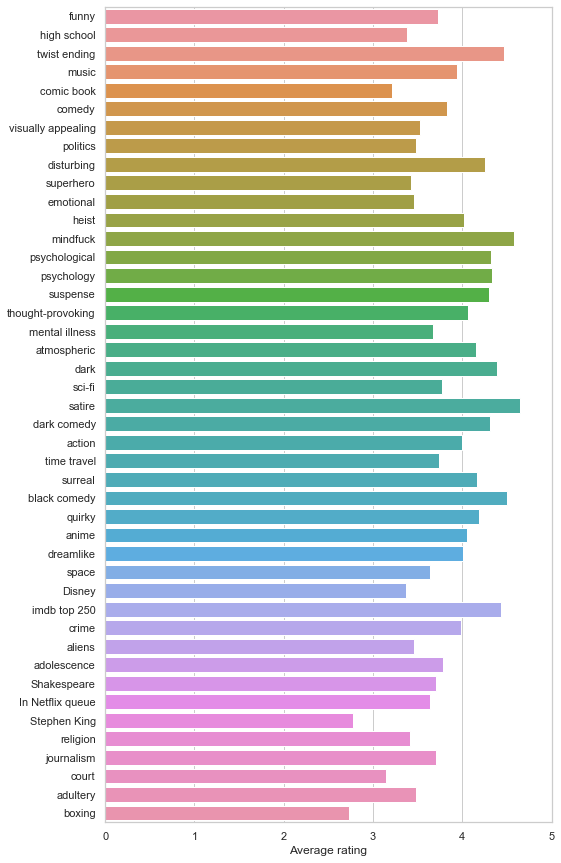

In [4]:
select_tag = []
select_rate = []
for t in tag2rate:
    if len(tag2rate[t]) > 10:
        select_tag.append(t)
        select_rate.append(np.mean(tag2rate[t])*5)
        
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 15))
sns.barplot(x=select_rate, y=select_tag)
ax.set(xlim=(0, 5), ylabel="",
       xlabel="Average rating")

The fig shows some interesting finding, for example, imdb top 250 associated with rating nearly 4.5, which is waht we expected. Also, the sci-fi and superhero movies normally have relatively lower ratings. 

# Part B: recommendation based on clustering

Tag seems hard to be used for recommendation, so I am not going to use it.

For recommendation, I am going to use K-means, MeanShif, and Birch clustering model, to cluster movies based on the genres of all movies. I am going to use tf-idf first to transfer the text into numbers.

For each model, I am going count its accuracy of recommendation per user. For each user, I am going to pick their highly-rated movies and then use the trained model to cluster them, if more than 1 of them belong to the same cluster, I would consider the model succeeds, otherwise fail.


## Data split

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

# Preprocessing and tokenizing
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

all_gener = []
for gen in df_movies['genres']:
    line = gen.lower()
    all_gener.append(line)
    
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing)
tfidf = tfidf_vectorizer.fit_transform(all_gener)
    

In [6]:
genre_per_user = {}
for usr in df_ratings['userId'].unique():
    genre_per_user[usr] = []
    their_moive = df_ratings[df_ratings['userId'] == usr]
    cutoff = their_moive['rating'].max()
    prefer = their_moive[their_moive['rating'] >= cutoff]
    for moive in prefer['movieId'].unique():
        this_gen = df_movies[df_movies['movieId'] == moive]['genres'].iloc[0]
        genre_per_user[usr].append(this_gen)


## Model: K-means

In [7]:
from sklearn.cluster import KMeans
kmeans_50 = KMeans(n_clusters=50).fit(tfidf)
print("10-cluster:")
print(kmeans_50.predict(tfidf_vectorizer.transform(genre_per_user[1])))

kmeans_100 = KMeans(n_clusters=100).fit(tfidf)
print("10-cluster:")
print(kmeans_100.predict(tfidf_vectorizer.transform(genre_per_user[1])))


10-cluster:
[ 7  7 43 39 11  0  3 43  4  3 31 38 49  0 47 40 47 47  7 22  2 47 47 47
 47 47 47 22 47  3  7  7 33 21  4 21 22 36  4 26 13 49 39 15 36 11  4 21
 16 47 22 13 22 10 21 24  7 20 26 39  2  9 12 44 12  7 47 12  4 21 44 12
 12 12  9 45 26 17 20 14 39 34 43 20 36  5 36 20 14 36 42 46 47 36 12 15
 21 12 39 22 22 22 10 44 22 22 33 47 21 49 26  3 35  7 39 11  3 22  0  4
  4 10  4 11]
10-cluster:
[41 20 73 59 76 21  1 50  2  1 52 31 10 98 36  7 36 92 66 43  0 36 36 36
 36 92 36 57 92  1 20 20 89 75  2 14 57 26  2 28 18 10 59 16 26 18 79 14
 37 36 57 78 57 88 14 34 94 30 28 82  0 33 45 58 45 20 36 11  2 14 58 45
 11 11 33 27 28 60 30  9 82 29 50 30 99 77 26 30  9 99 84 97 36 99 89 16
 75 11 82 44 44 44 88 58 44 44 48 36 75 10 28  1 62 94 82 76  1 57 21  2
  2 88  2 76]


using the defined measure, K-means with lower clusters will always give 100% accuracy, so it's not a good measure!!!

Instead I am going to randomly use the moive with same tag to check the clustering result. I am not going to use all tag, but those with more than 15 moives. And I am only going to show the result with 3 tag, 'sci-fi', 'Disney' and 'twist ending'. 'sci-fi' is supposed to be a easy tag because it's also a genre, 'Disney' is easy too for the majority of Disney are anime or similar. On the other hand, 'twist ending' is tricky because every movie could be tagged as 'twist ending' and no genre seems perfect fit it.

In [8]:
genre_per_tag = {}
""" movieId              tag"""
cnt = 0
for tag in df_tags['tag'].unique():
    if df_tags[df_tags['tag'] == tag].shape[0] > 15:
        genre_per_tag[tag] = []
        this_tag = df_tags[df_tags['tag'] == tag]
        for movie in this_tag['movieId'].unique():
            this_gen = df_movies[df_movies['movieId'] == movie]['genres'].iloc[0]
            genre_per_tag[tag].append(this_gen)
print(genre_per_tag.keys())

dict_keys(['funny', 'twist ending', 'music', 'sci-fi', 'dark comedy', 'quirky', 'Disney', 'atmospheric', 'superhero', 'visually appealing', 'surreal', 'politics', 'time travel', 'suspense', 'psychology', 'thought-provoking', 'mental illness', 'crime', 'In Netflix queue', 'religion'])


In [9]:
print('50:  ' + str(kmeans_50.predict(tfidf_vectorizer.transform(genre_per_tag['sci-fi']))))
print('100: ' + str(kmeans_100.predict(tfidf_vectorizer.transform(genre_per_tag['sci-fi']))))
print('50:  ' + str(kmeans_50.predict(tfidf_vectorizer.transform(genre_per_tag['Disney']))))
print('100: ' + str(kmeans_100.predict(tfidf_vectorizer.transform(genre_per_tag['Disney']))))
print('50:  ' + str(kmeans_50.predict(tfidf_vectorizer.transform(genre_per_tag['twist ending']))))
print('100: ' + str(kmeans_100.predict(tfidf_vectorizer.transform(genre_per_tag['twist ending']))))


50:  [37 36  4 36 36 36 36  4 36 36 37  4 37  4 37  4  4]
100: [46 71  2 26 71 26 99  2 26 26 46  2 46  2 46 69 79]
50:  [44 47 47 47 47 47 12 31 47 47 47 47 47 47 12 47  9 47 12 12 12 12]
100: [58 36 36 36 36 36 45 22 36 36 92 36 36 36 45 36 89 36 45 11 11 11]
50:  [ 7  7  7 35 40  7  7  7  7 10  7  7 36 32 40]
100: [20 20 41 62  7 41 20 20 94 88 94 20 99 67  7]


GOOD!!! K-means did well on 'sci-fi' and 'Disney', but okay on 'twist ending', as we expected.

## Model: MeanShift

In [10]:
from sklearn.cluster import MeanShift
meanshift_6 = MeanShift(bandwidth=.6)
meanshift_6.fit(tfidf.toarray())
meanshift_5 = MeanShift(bandwidth=.5)
meanshift_5.fit(tfidf.toarray())


MeanShift(bandwidth=0.5, bin_seeding=False, cluster_all=True, min_bin_freq=1,
          n_jobs=None, seeds=None)

The parameter is difficult to reasonale, I trial-error to find that 0.6 and 0.5 might be the most reasonable ones.

In [11]:
print("0.6: " + str(meanshift_6.predict(tfidf_vectorizer.transform(genre_per_tag['sci-fi']))))
print("0.5: " + str(meanshift_5.predict(tfidf_vectorizer.transform(genre_per_tag['sci-fi']))))
print("0.6: " + str(meanshift_6.predict(tfidf_vectorizer.transform(genre_per_tag['Disney']))))
print("0.5: " + str(meanshift_5.predict(tfidf_vectorizer.transform(genre_per_tag['Disney']))))
print("0.6: " + str(meanshift_6.predict(tfidf_vectorizer.transform(genre_per_tag['twist ending']))))
print("0.5: " + str(meanshift_5.predict(tfidf_vectorizer.transform(genre_per_tag['twist ending']))))




0.6: [30 23  3  3 23  3  3  3  3  3 30  3 30  3 30 23  3]
0.5: [ 40  38  12   7  38   7   7  12   7   7  40  12  40  12  40 126  12]
0.6: [21 39 25 25 39 25 13 18 25 25 25 25 25 25 13 25 13 25 46 13 13 13]
0.5: [ 22 106  41  41 106  41  19  21  41  41  62  41  41  41  19  41  47  41
  19  19  19  19]
0.6: [ 8  8  8  8  5  8  8  8  8 10  8  8  3 27  5]
0.5: [17 17 17 25 11 17 17 17 17 16 17 17  7 43 11]


## Model: Birch

In [12]:
from sklearn.cluster import Birch
birch_6 = Birch(branching_factor=50, n_clusters=None, threshold=0.6, compute_labels=True)
birch_6.fit(tfidf)

birch_5 = Birch(branching_factor=50, n_clusters=None, threshold=0.5, compute_labels=True)
birch_5.fit(tfidf)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=None,
      threshold=0.5)

In [13]:
print("0.6: " + str(birch_6.predict(tfidf_vectorizer.transform(genre_per_tag['sci-fi']))))
print("0.5: " + str(birch_5.predict(tfidf_vectorizer.transform(genre_per_tag['sci-fi']))))
print("0.6: " + str(birch_6.predict(tfidf_vectorizer.transform(genre_per_tag['Disney']))))
print("0.5: " + str(birch_5.predict(tfidf_vectorizer.transform(genre_per_tag['Disney']))))
print("0.6: " + str(birch_6.predict(tfidf_vectorizer.transform(genre_per_tag['twist ending']))))
print("0.5: " + str(birch_5.predict(tfidf_vectorizer.transform(genre_per_tag['twist ending']))))




0.6: [21 19  6  6 19  6  6  6  6  6 21  6 21  6 21 19  6]
0.5: [79 31 48 32 80 12 12 48 12 12 79 48 79 48 79 74 48]
0.6: [20 20 20 18 18 18 20  0 18 18 18 18 20 20 20 18 19 18 20 20 20 20]
0.5: [67 82 23 78 92 78 67  8 78 78 95 23 23 78 67 78 94 23 86 67 67 67]
0.6: [8 8 8 8 5 8 8 8 8 5 8 8 6 6 5]
0.5: [40 40 38 42  6 38 40 40 38  1 38 40 12 45  6]


MeanShift and Birch will be able to clustering tag 'twist ending' with proper parameter setting, even the other 2 tags seems fine, such as using threshold=0.6 for birch or bandwidth=0.6 for mean shift.

But it took a while to train MeanShift.